## PIV Movie of all 3 levels of run T02

In [5]:
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline
from netCDF4 import Dataset
import numpy as np
import scipy.io as sio

In [6]:
idalia_land = '#8b7765'
def rotate(x_comp, y_comp, angle):
    '''Input:
        x_comp:: x component of vector
        y_comp:: y component of vector
       angle:: in radians.
       Returns:
       Rotated componets of vector x_rot and y_rot'''
    x_rot = x_comp*np.cos(angle)-(y_comp)*np.sin(angle)
    y_rot = x_comp*np.sin(angle)+(y_comp)*np.cos(angle)
    return(x_rot, y_rot)

def get_field(varname, filepath):
    '''
    file:: str, path to file
    name:: str, variable name (eg 'typevector_filtered', 'velocity_magnitude', 'x','y','u_filtered', 'v_filtered', etc.)
    '''
    mat = sio.loadmat(filepath, squeeze_me=True)
    var = mat[varname]
    return(var)

def get_mask(filepath, fr=0):
    '''Get the mask from a PIV mat file.'''
    mat = sio.loadmat(filepath, squeeze_me=True)
    mask_PIV = np.ma.masked_values(mat['typevector_filtered'][0],0)
    mask = np.ma.getmask(mask_PIV)
    return(mask)

def get_insert_bathy(angle, H = 0.092):
    ''' Get the bathymetry of the canyon insert and x,y coordinates rotated by an angle
    
    INPUT
    angle:: float, angle in radians, positive angle rotates counterclockwise
    H:: float, max depth of water column in meters
    
    RETURNS
    xIns_rot, yIns_rot, x and y coordinates rotated by angle (2D arrays)
    depth_ins, 2D array with depth values'''
    
    insert_file = '/ocean/kramosmu/Building_canyon/BuildCanyon/Bathymetry/tank/BathyInsert03.nc'
    H = 0.092 # m, max water level

    with Dataset(insert_file, 'r') as nbl:
        Xins = nbl.variables['X'][:]
        Yins = nbl.variables['Y'][:]
        depth_ins = (nbl.variables['Bathymetry'][:])-H

    xIns_rot = Xins*np.cos(angle)-(Yins)*np.sin(angle)
    yIns_rot = Xins*np.sin(angle)+(Yins)*np.cos(angle)
    return(xIns_rot, yIns_rot, depth_ins)

def get_plot_data(fr, filepath, angle, mask):
    x_orig = get_field('x', filepath) #(fr,y,x)
    y_orig = -get_field('y', filepath)
    x,y = rotate(x_orig, y_orig, angle)

    u_orig = get_field('u_filtered', filepath) #(fr,y,x)
    v_orig = -get_field('v_filtered', filepath)
    u,v = rotate(u_orig, v_orig, angle)

    spd = get_field('velocity_magnitude', filepath) #(fr,y,x)
    x_ma = 100*np.ma.masked_array(x[fr], mask=mask)
    y_ma = 100*np.ma.masked_array(y[fr], mask=mask)
    u_ma = 100*np.ma.masked_array(u[fr], mask=mask)
    v_ma = 100*np.ma.masked_array(v[fr], mask=mask)
    spd_ma =100* np.ma.masked_array(spd[fr],mask=mask)

    U = u_ma / np.sqrt(u_ma**2 + v_ma**2);
    V = v_ma / np.sqrt(u_ma**2 + v_ma**2);
    return(x_ma,y_ma,u_ma,v_ma,spd_ma,U,V)

In [7]:
# Set file paths
filepath1 = '../exp_01aug19/frames/run01/T02_run01_PIV.mat'
filepath2 = '../exp_01aug19/frames/run02/T02_run02_piv.mat'
filepath3 = '../exp_01aug19/frames/run03/T01_run03_PIV.mat'

In [8]:
# get masks variables shape is (fr,y,x)

mask1 = get_mask(filepath1) # (y,x)
mask2 = get_mask(filepath2) # (y,x)
mask3 = get_mask(filepath3) # (y,x)

angle = 48.5*np.pi/180  # rot angle piv output
angle1 = 68.5*np.pi/180 # rot angle first insert bathymetry
angle2 = 90.0*np.pi/180 # rot angle secons insert bathymetry



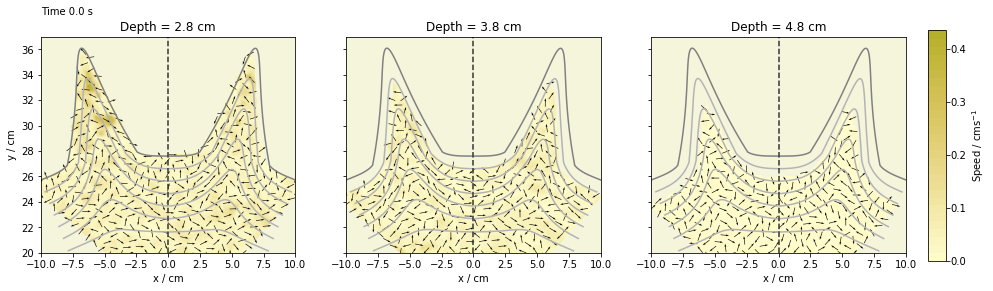

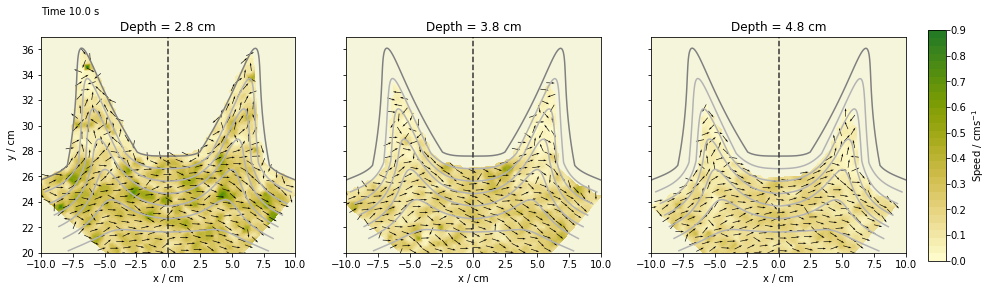

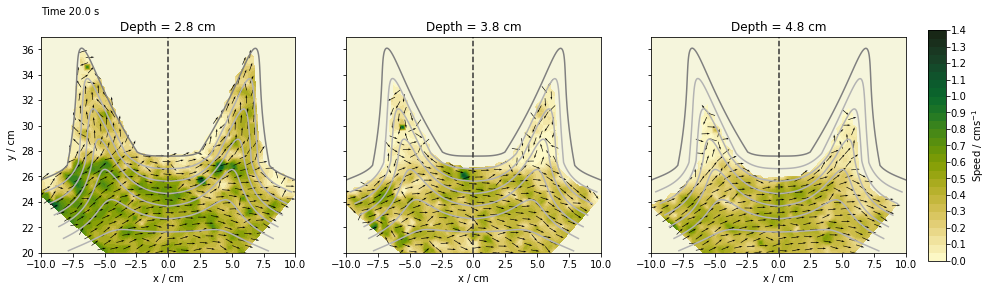

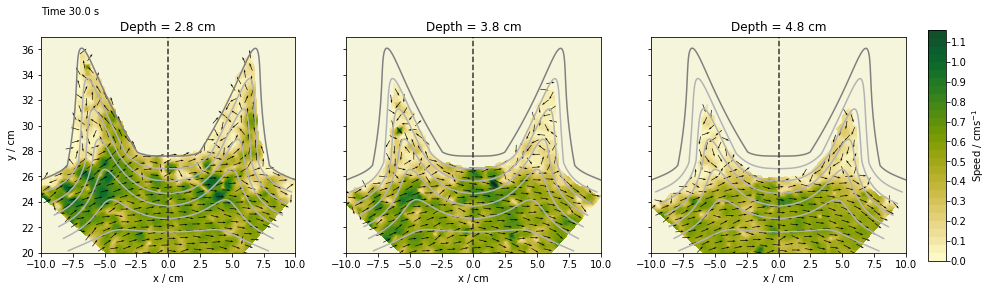

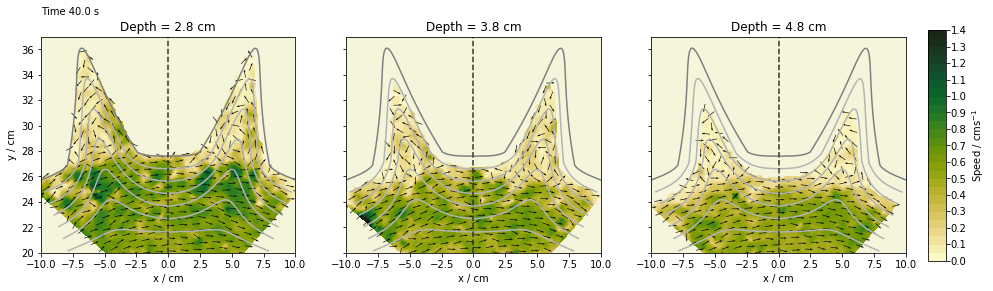

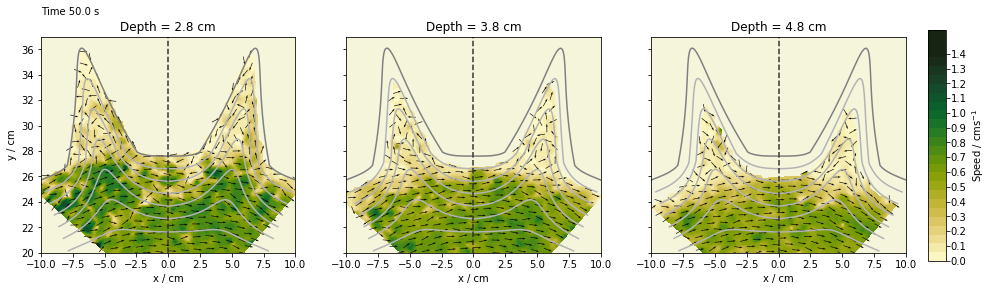

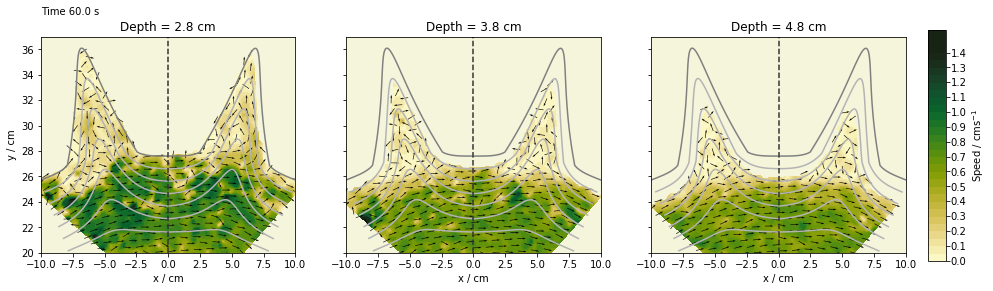

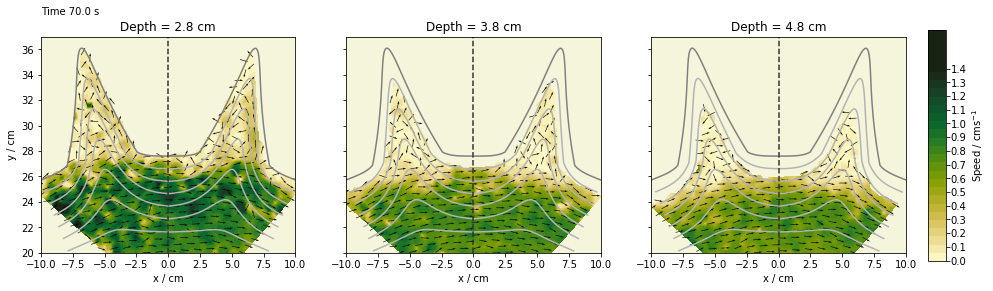

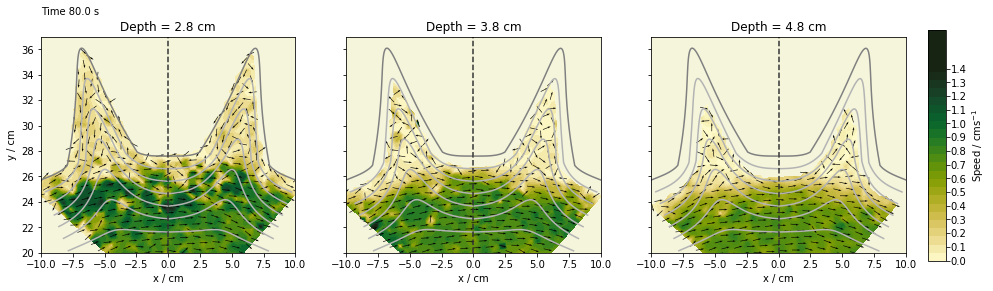

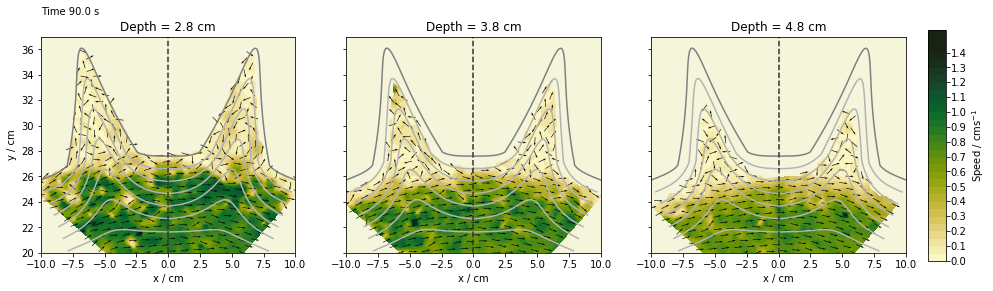

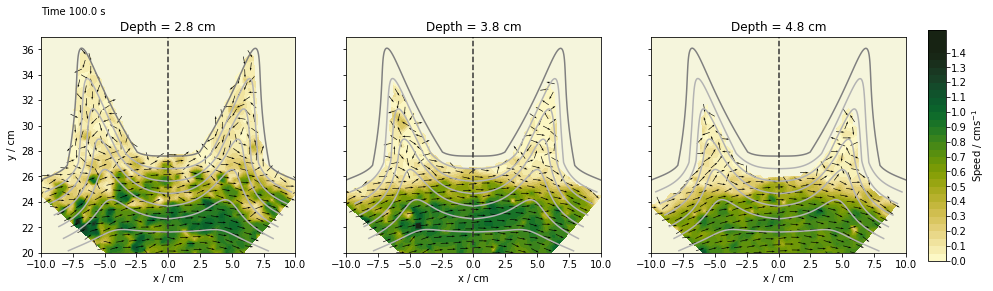

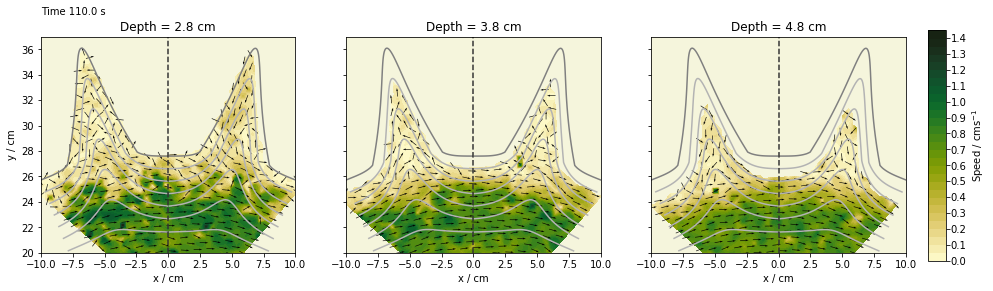

In [9]:
# normalized quiver
max_spd = 1.4
min_spd = 0
cbar_ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]
for fr in range(0,600,50):
    fig,(ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(15.5,4), sharey=True)
    ax0.set_facecolor('beige')
    ax1.set_facecolor('beige')
    ax2.set_facecolor('beige')

    #frame data
    x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1,U1,V1 = get_plot_data(fr, filepath1, angle, mask1)
    x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2,U2,V2 = get_plot_data(fr, filepath2, angle, mask2)
    x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3,U3,V3 = get_plot_data(fr, filepath3, angle, mask3)

    # plot data 1
    cf = ax0.contourf(x_ma1-24.2,y_ma1+21.,spd_ma1,30,
                cmap=cmo.cm.speed, vmin=min_spd, vmax=max_spd) 
                # pcolormesh does not work with masked arrays
    cbar_ax = fig.add_axes([0.92, 0.1, 0.016, 0.8])
    cb = plt.colorbar(cf, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    cb.ax.yaxis.set_tick_params(pad=1)
    cb.set_label('Speed / cms$^{-1}$')
    
    qv = ax0.quiver(x_ma1[::2,::2]-24.2,y_ma1[::2,::2]+21.0,U1[::2,::2],V1[::2,::2],
                    scale=30, color='k', units='width',pivot='middle')

    x_ins, y_ins, depth_ins = get_insert_bathy(angle1)
    x_ins2, y_ins2, depth_ins2 = get_insert_bathy(angle2)
    cnt1 = ax0.contour(x_ins*100,y_ins*100,-depth_ins*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    cnt2 = ax0.contour(x_ins2*100,y_ins2*100,-depth_ins2*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    
     # plot data 2
    cf = ax1.contourf(x_ma2-24.2,y_ma2+21.,spd_ma2,30,cmap=cmo.cm.speed, vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    cb.set_label('Speed / cms$^{-1}$')
    qv = ax1.quiver(x_ma2[::2,::2]-24.2,y_ma2[::2,::2]+21.0,U2[::2,::2],V2[::2,::2],scale=30, color='k', units='width',pivot='middle')

    x_ins, y_ins, depth_ins = get_insert_bathy(angle1)
    x_ins2, y_ins2, depth_ins2 = get_insert_bathy(angle2)
    cnt1 = ax1.contour(x_ins*100,y_ins*100,-depth_ins*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8],
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    cnt2 = ax1.contour(x_ins2*100,y_ins2*100,-depth_ins2*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8],
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    
     # plot data 3
    cf = ax2.contourf(x_ma3-24.2,y_ma3+21.,spd_ma3,30,cmap=cmo.cm.speed, 
                      vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    qv = ax2.quiver(x_ma3[::2,::2]-24.2,y_ma3[::2,::2]+21.0,U3[::2,::2],V3[::2,::2],
                    scale=30, color='k', units='width',pivot='middle')

    x_ins, y_ins, depth_ins = get_insert_bathy(angle1)
    x_ins2, y_ins2, depth_ins2 = get_insert_bathy(angle2)
    cnt1 = ax2.contour(x_ins*100,y_ins*100,-depth_ins*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8],
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    cnt2 = ax2.contour(x_ins2*100,y_ins2*100,-depth_ins2*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8],
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])


    ax0.set_ylabel('y / cm')
    ax0.set_xlabel('x / cm')
    ax1.set_xlabel('x / cm')
    ax2.set_xlabel('x / cm')
    ax0.set_title('Depth = 2.8 cm')
    ax1.set_title('Depth = 3.8 cm')
    ax2.set_title('Depth = 4.8 cm')
    ax0.text(0.0,1.1,'Time %1.1f s' %(fr/5), transform=ax0.transAxes)
    ax0.axvline(0, color='0.2', linestyle='--')
    ax1.axvline(0, color='0.2', linestyle='--')
    ax2.axvline(0, color='0.2', linestyle='--')
    
    ax0.set_aspect(1)
    ax1.set_aspect(1)
    ax2.set_aspect(1)

    ax0.set_xlim(-10,10)
    ax0.set_ylim(20,37)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(20,37)
    ax2.set_xlim(-10,10)
    ax2.set_ylim(20,37)
    
    plt.savefig('T02_fr%d.pdf' %fr, fmt='pdf')

### 10 s means

In [ ]:
# normalized quiver
max_spd = 1.4
min_spd = 0
cbar_ticks = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1,1.1,1.2,1.3,1.4]

x1 = get_field('x', filepath1)[0]
x2 = get_field('x', filepath2)[0]
x3 = get_field('x', filepath3)[0]

nt = 50
for fr in range(0,600,nt):
    fig,(ax0,ax1,ax2) = plt.subplots(1, 3, figsize=(15.5,4), sharey=True)
    ax0.set_facecolor('beige')
    ax1.set_facecolor('beige')
    ax2.set_facecolor('beige')
    
    #frame data
    spd_ma1 = np.empty((nt,np.shape(x1)[0],np.shape(x1)[1]))
    U1 = np.empty((nt,np.shape(x1)[0],np.shape(x1)[1]))
    V1 = np.empty((nt,np.shape(x1)[0],np.shape(x1)[1]))
    
    spd_ma2 = np.empty((nt,np.shape(x2)[0],np.shape(x2)[1]))
    U2 = np.empty((nt,np.shape(x2)[0],np.shape(x2)[1]))
    V2 = np.empty((nt,np.shape(x2)[0],np.shape(x2)[1]))
    
    spd_ma3 = np.empty((nt,np.shape(x3)[0],np.shape(x3)[1]))
    U3 = np.empty((nt,np.shape(x3)[0],np.shape(x3)[1]))
    V3 = np.empty((nt,np.shape(x3)[0],np.shape(x3)[1]))
  
    for ii in range(nt):
        x_ma1,y_ma1,u_ma1,v_ma1,spd_ma1[ii,:,:],U1[ii,:,:],V1[ii,:,:] = \
        get_plot_data(fr, filepath1, angle, mask1)
        x_ma2,y_ma2,u_ma2,v_ma2,spd_ma2[ii,:,:],U2[ii,:,:],V2[ii,:,:] = \
        get_plot_data(fr, filepath2, angle, mask2)
        x_ma3,y_ma3,u_ma3,v_ma3,spd_ma3[ii,:,:],U3[ii,:,:],V3[ii,:,:] = \
        get_plot_data(fr, filepath3, angle, mask3)
    
    # plot data 1
    spd_mean1 = np.nanmean(spd_ma1, axis=0)
    u_mean1 = np.nanmean(U1, axis=0)
    v_mean1 = np.nanmean(V1, axis=0)
    #cf = ax0.contourf(x_ma1-24.2,y_ma1+21.,spd_mean1,30,
    #                  cmap=cmo.cm.speed, 
    #                  vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    #cbar_ax = fig.add_axes([0.92, 0.1, 0.016, 0.8])
    #cb = plt.colorbar(cf, cax=cbar_ax, ticks=cbar_ticks,format='%.1f')
    #cb.ax.yaxis.set_tick_params(pad=1)
    #cb.set_label('Speed / cms$^{-1}$')
    
    qv = ax0.quiver(x_ma1[::2,::2]-24.2,y_ma1[::2,::2]+21.0,
                    u_mean1[::2,::2],v_mean1[::2,::2],scale=30, 
                    color='k', units='width',pivot='middle')

    x_ins, y_ins, depth_ins = get_insert_bathy(angle1)
    x_ins2, y_ins2, depth_ins2 = get_insert_bathy(angle2)
    cnt1 = ax0.contour(x_ins*100,y_ins*100,-depth_ins*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    cnt2 = ax0.contour(x_ins2*100,y_ins2*100,-depth_ins2*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    
    # plot data 2
    spd_mean2 = np.nanmean(spd_ma2, axis=0)
    u_mean2 = np.nanmean(U2, axis=0)
    v_mean2 = np.nanmean(V2, axis=0)
   
    #cf = ax1.contourf(x_ma2-24.2,y_ma2+21.,spd_mean2,30,cmap=cmo.cm.speed,
    #                  vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    qv = ax1.quiver(x_ma2[::2,::2]-24.2,y_ma2[::2,::2]+21.0,
                    u_mean2[::2,::2],v_mean2[::2,::2],scale=30,
                    color='k', units='width',pivot='middle')

    x_ins, y_ins, depth_ins = get_insert_bathy(angle1)
    x_ins2, y_ins2, depth_ins2 = get_insert_bathy(angle2)
    cnt1 = ax1.contour(x_ins*100,y_ins*100,-depth_ins*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    cnt2 = ax1.contour(x_ins2*100,y_ins2*100,-depth_ins2*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    
    # plot data 3
    spd_mean3 = np.nanmean(spd_ma3, axis=0)
    u_mean3 = np.nanmean(U3, axis=0)
    v_mean3 = np.nanmean(V3, axis=0)
   
    #cf = ax2.contourf(x_ma3-24.2,y_ma3+21.,spd_mean3,30,cmap=cmo.cm.speed, 
    #                  vmin=min_spd, vmax=max_spd) # pcolormesh does not work with masked arrays
    qv = ax2.quiver(x_ma3[::2,::2]-24.2,y_ma3[::2,::2]+21.0,
                    u_mean3[::2,::2],v_mean3[::2,::2],
                    scale=30, color='k', units='width',pivot='middle')

    x_ins, y_ins, depth_ins = get_insert_bathy(angle1)
    x_ins2, y_ins2, depth_ins2 = get_insert_bathy(angle2)
    cnt1 = ax2.contour(x_ins*100,y_ins*100,-depth_ins*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])
    cnt2 = ax2.contour(x_ins2*100,y_ins2*100,-depth_ins2*100,
                       levels=[2.8,3.8,4.8,5.8,6.8,7.8,8.8], 
                       colors=['0.5','0.7','0.7','0.7','0.7','0.7','0.7'])


    ax0.set_ylabel('y / cm')
    ax0.set_xlabel('x / cm')
    ax1.set_xlabel('x / cm')
    ax2.set_xlabel('x / cm')
    ax0.set_title('Depth = 2.8 cm')
    ax1.set_title('Depth = 3.8 cm')
    ax2.set_title('Depth = 4.8 cm')
    ax0.text(0.0,1.1,'Time %1.1f s' %(fr/5), transform=ax0.transAxes)
    ax0.axvline(0, color='0.2', linestyle='--')
    ax1.axvline(0, color='0.2', linestyle='--')
    ax2.axvline(0, color='0.2', linestyle='--')
    
    ax0.set_aspect(1)
    ax1.set_aspect(1)
    ax2.set_aspect(1)

    ax0.set_xlim(-10,10)
    ax0.set_ylim(20,37)
    ax1.set_xlim(-10,10)
    ax1.set_ylim(20,37)
    ax2.set_xlim(-10,10)
    ax2.set_ylim(20,37)
    
    plt.savefig('T02_mean_fr%d.pdf' %fr, fmt='pdf')

In [26]:
np.shape(spd_ma1)

(10, 61, 58)

In [27]:
np.shape(spd_mean1)

(61, 58)

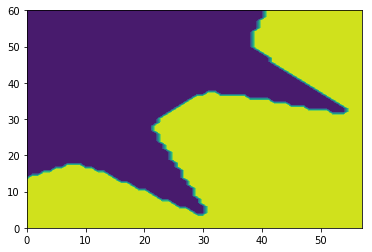

In [29]:
plt.contourf(spd_mean1)

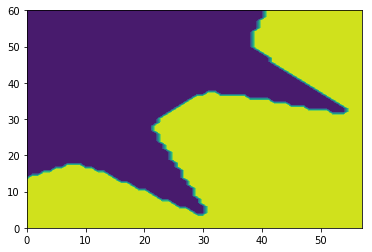

In [30]:
plt.contourf(spd_ma1[0,:,:])

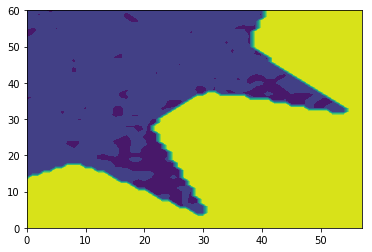

In [34]:
plt.contourf(u_mean1[:,:])